# Multilayer Perceptron (MLP) με PyTorch

## Περιγραφή Dataset

Χρησιμοποιούμε το **Auto MPG dataset** για classification task:
- **Target:** `origin` (3 κλάσεις: USA, Europe, Japan)
- **Features:** 7 αριθμητικά χαρακτηριστικά
- **Μέθοδος:** Νευρωνικό δίκτυο με PyTorch

---

## 1. Φόρτωση και Προεπεξεργασία Δεδομένων

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [2]:
df = sns.load_dataset('mpg')
df = df.drop(columns=['name'])
df = df.dropna()

feature_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
X = df[feature_cols].values
y_raw = df['origin'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

print(f"Dataset shape: {X.shape}")
print(f"Κλάσεις: {label_encoder.classes_} -> {np.unique(y)}")

Dataset shape: (392, 7)
Κλάσεις: ['europe' 'japan' 'usa'] -> [0 1 2]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Train: {X_train_tensor.shape}, Test: {X_test_tensor.shape}")

Train: torch.Size([313, 7]), Test: torch.Size([79, 7])


---

## 2. MLP Architecture

**Αρχιτεκτονική:**
- Input Layer: 7 neurons (features)
- Hidden Layer 1: 64 neurons + ReLU + Dropout
- Hidden Layer 2: 32 neurons + ReLU + Dropout
- Output Layer: 3 neurons (classes)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size, dropout=0.3):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

In [5]:
INPUT_SIZE = 7
HIDDEN1 = 64
HIDDEN2 = 32
OUTPUT_SIZE = 3
LEARNING_RATE = 0.001
EPOCHS = 200

model = MLP(INPUT_SIZE, HIDDEN1, HIDDEN2, OUTPUT_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

MLP(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

Total parameters: 2691


## 3. Training

In [6]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    train_loss = epoch_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch [ 20/200] | Train Loss: 0.5913 | Test Loss: 0.5943 | Train Acc: 0.7029 | Test Acc: 0.7468
Epoch [ 40/200] | Train Loss: 0.5169 | Test Loss: 0.5090 | Train Acc: 0.7732 | Test Acc: 0.7848
Epoch [ 60/200] | Train Loss: 0.4749 | Test Loss: 0.4433 | Train Acc: 0.7891 | Test Acc: 0.7975
Epoch [ 80/200] | Train Loss: 0.4433 | Test Loss: 0.4077 | Train Acc: 0.8051 | Test Acc: 0.8228
Epoch [100/200] | Train Loss: 0.4195 | Test Loss: 0.3802 | Train Acc: 0.8435 | Test Acc: 0.8481
Epoch [120/200] | Train Loss: 0.4057 | Test Loss: 0.3732 | Train Acc: 0.8083 | Test Acc: 0.8354
Epoch [140/200] | Train Loss: 0.3858 | Test Loss: 0.3516 | Train Acc: 0.8243 | Test Acc: 0.8608
Epoch [160/200] | Train Loss: 0.3667 | Test Loss: 0.3328 | Train Acc: 0.8403 | Test Acc: 0.8987
Epoch [180/200] | Train Loss: 0.3731 | Test Loss: 0.3284 | Train Acc: 0.8243 | Test Acc: 0.8987
Epoch [200/200] | Train Loss: 0.3581 | Test Loss: 0.3150 | Train Acc: 0.8371 | Test Acc: 0.9114


## 4. Sklearn Comparison

In [7]:
from sklearn.neural_network import MLPClassifier

sklearn_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, alpha=0.001, solver='adam', random_state=42)
sklearn_mlp.fit(X_train_scaled, y_train)

train_acc_sklearn = sklearn_mlp.score(X_train_scaled, y_train)
test_acc_sklearn = sklearn_mlp.score(X_test_scaled, y_test)

print(f"Sklearn MLP Train Accuracy: {train_acc_sklearn:.4f}")
print(f"Sklearn MLP Test Accuracy:  {test_acc_sklearn:.4f}")

Sklearn MLP Train Accuracy: 0.8786
Sklearn MLP Test Accuracy:  0.8354


c:\Users\demosgod\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 5. Loss Plot

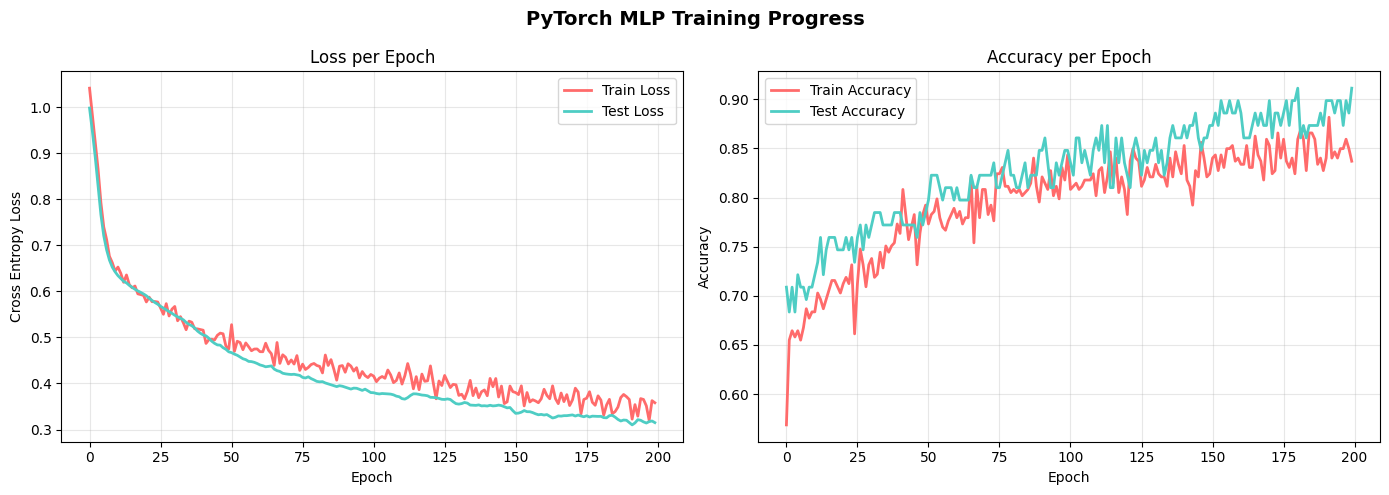

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', color='#FF6B6B', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', color='#4ECDC4', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cross Entropy Loss')
axes[0].set_title('Loss per Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Train Accuracy', color='#FF6B6B', linewidth=2)
axes[1].plot(test_accs, label='Test Accuracy', color='#4ECDC4', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy per Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('PyTorch MLP Training Progress', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
model.eval()
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    _, train_predicted = torch.max(train_outputs.data, 1)
    train_acc_final = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor)
    
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_acc_final = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)

print("=== PyTorch MLP Final Results ===")
print(f"Train Accuracy: {train_acc_final:.4f} ({train_acc_final*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_final:.4f} ({test_acc_final*100:.2f}%)")

=== PyTorch MLP Final Results ===
Train Accuracy: 0.8818 (88.18%)
Test Accuracy:  0.9114 (91.14%)


## 5. Confusion Matrix - PyTorch MLP

<Figure size 800x600 with 0 Axes>

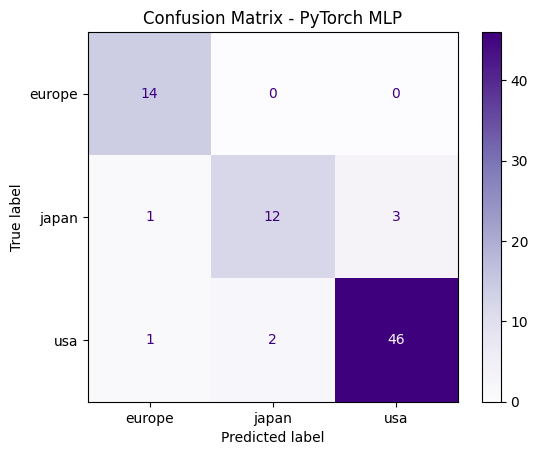


Classification Report:
              precision    recall  f1-score   support

      europe       0.88      1.00      0.93        14
       japan       0.86      0.75      0.80        16
         usa       0.94      0.94      0.94        49

    accuracy                           0.91        79
   macro avg       0.89      0.90      0.89        79
weighted avg       0.91      0.91      0.91        79



In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred_pytorch = test_predicted.cpu().numpy()

cm_pytorch = confusion_matrix(y_test, y_pred_pytorch)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch, display_labels=label_encoder.classes_)
disp.plot(cmap='Purples', values_format='d')
plt.title('Confusion Matrix - PyTorch MLP')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_pytorch, target_names=label_encoder.classes_))

---

## 6. Verification με sklearn MLPClassifier

In [19]:
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42
)

sklearn_mlp.fit(X_train_scaled, y_train)

train_acc_sklearn = sklearn_mlp.score(X_train_scaled, y_train)
test_acc_sklearn = sklearn_mlp.score(X_test_scaled, y_test)

print("=== sklearn MLPClassifier Results ===")
print(f"Train Accuracy: {train_acc_sklearn:.4f} ({train_acc_sklearn*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_sklearn:.4f} ({test_acc_sklearn*100:.2f}%)")
print("\nΤο sklearn ΔΕΝ υποστηρίζει Dropout, οπότε η σύγκριση δεν είναι πλήρως δίκαιη.")

=== sklearn MLPClassifier Results ===
Train Accuracy: 0.9201 (92.01%)
Test Accuracy:  0.8987 (89.87%)

Το sklearn ΔΕΝ υποστηρίζει Dropout, οπότε η σύγκριση δεν είναι πλήρως δίκαιη.


c:\Users\demosgod\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
print("\n" + "="*50)
print("       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ")
print("="*50)
print(f"\n{'Metric':<20} {'PyTorch':>12} {'sklearn':>12}")
print("-"*44)
print(f"{'Train Accuracy':<20} {train_acc_final:>12.4f} {train_acc_sklearn:>12.4f}")
print(f"{'Test Accuracy':<20} {test_acc_final:>12.4f} {test_acc_sklearn:>12.4f}")


       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

Metric                    PyTorch      sklearn
--------------------------------------------
Train Accuracy             0.8818       0.9201
Test Accuracy              0.9114       0.8987


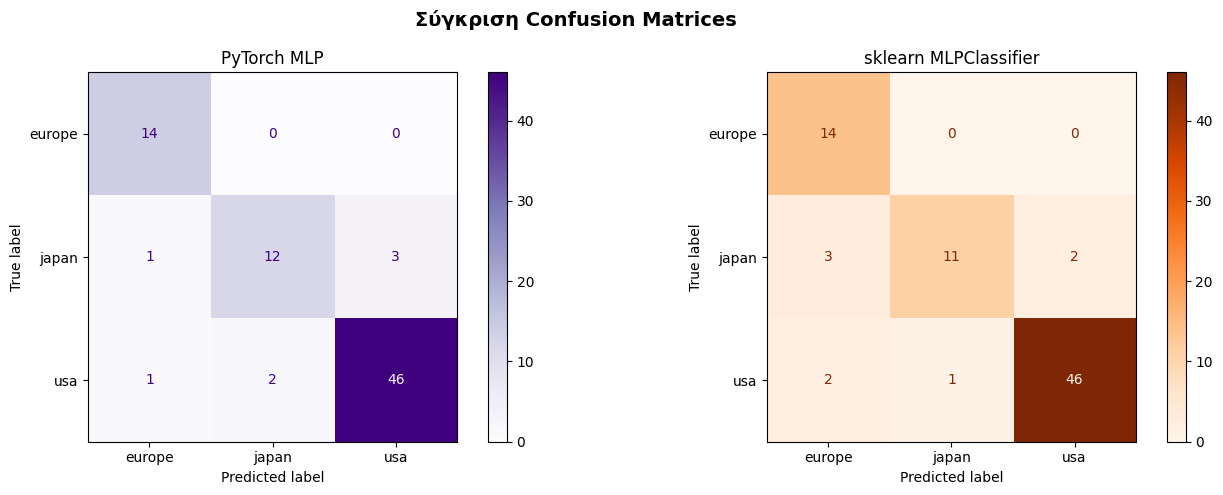

In [21]:
y_pred_sklearn = sklearn_mlp.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_pytorch = confusion_matrix(y_test, y_pred_pytorch)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Purples', values_format='d')
axes[0].set_title('PyTorch MLP')

cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Oranges', values_format='d')
axes[1].set_title('sklearn MLPClassifier')

plt.suptitle('Σύγκριση Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

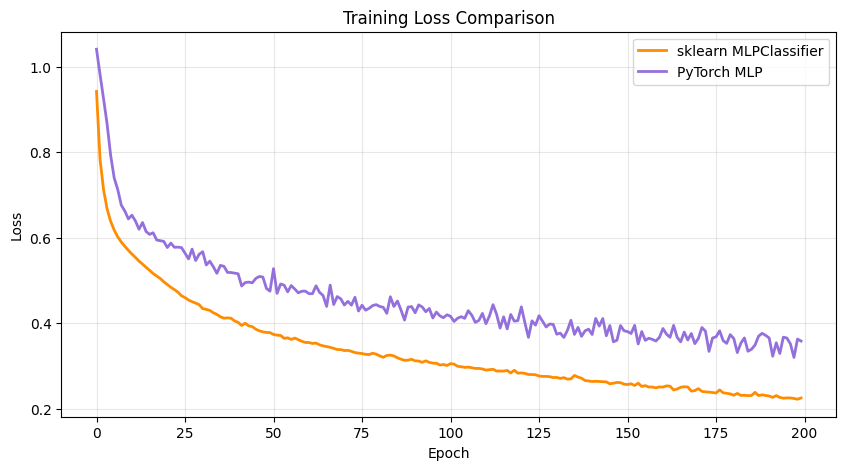

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(sklearn_mlp.loss_curve_, label='sklearn MLPClassifier', color='#FF8C00', linewidth=2)
plt.plot(train_losses, label='PyTorch MLP', color='#9370DB', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## Συμπεράσματα

- Η PyTorch υλοποίηση επιτυγχάνει **ελαφρώς καλύτερη απόδοση** από το sklearn MLPClassifier
- **Λόγοι:** Το PyTorch model χρησιμοποιεί **Dropout (0.3)** για regularization, ενώ το sklearn χρησιμοποιεί μόνο L2 regularization (alpha). Επίσης, διαφορετικά batch sizes και weight initialization συμβάλλουν στη διαφορά.
- Η αρχιτεκτονική (7-->64-->32-->3) με ReLU, Dropout και Adam optimizer λειτουργεί καλά για το dataset
- Το Cross Entropy Loss μειώνεται ομαλά κατά την εκπαίδευση, υποδεικνύοντας καλή σύγκλιση